In [1]:
import numpy as np
import pandas as pd

import pylab
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize
from scipy.stats import skew, kurtosis

In [2]:
df = pd.read_csv("2016 2017 BPAM Yield Matrix.csv", index_col = 0)
df.index = pd.to_datetime(df.index)
df.columns = pd.to_numeric(df.columns.values)
df.head()

,3,6,12,24,36,60,84,120,180,240,300,360
Date,,,,,,,,,,,,
2016-01-04,2.475,2.509,2.587,2.913,3.280,3.532,4.222,4.262,4.754,4.834,4.997,5.198
2016-01-05,2.469,2.503,2.580,2.916,3.295,3.512,4.180,4.275,4.765,4.846,5.010,5.214
2016-01-06,2.482,2.516,2.594,2.945,3.340,3.577,4.192,4.299,4.753,4.797,4.914,5.061
2016-01-07,2.543,2.577,2.656,2.986,3.357,3.592,4.189,4.304,4.758,4.801,4.919,5.068
2016-01-08,2.601,2.636,2.715,2.998,3.314,3.572,4.185,4.298,4.770,4.832,4.973,5.149


In [3]:
 df= df[df.index > np.datetime64("2017-10-01")]

In [4]:
def NelsonSiegelSvenssonParams(x,y):
    # parametric function, x is the independent variable
    # and c are the parameters.
    # it's a polynomial of degree 2
    fp = lambda c, x: (c[0])+ (c[1]*((1- np.exp(-x/c[4]))/(x/c[4])))+ (c[2]*((((1-np.exp(-x/c[4]))/(x/c[4])))- (np.exp(-x/c[4]))))+ (c[3]*((((1-np.exp(-x/c[5]))/(x/c[5])))- (np.exp(-x/c[5]))))
    
    # error function to minimize
    e = lambda p, x, y: ((fp(p,x)-y)**2).sum()
    p0 = np.array([0.01,0.01,0.01,0.01,1.00,1.00])    
    return (minimize(e, p0, args=(x,y)).x)

In [5]:
def evalNelsonSiegelSvensson(t,params):
    c = params
    j = []
    for h in t:
        #print(len(j))
        j.append((c[0])+ (c[1]*((1- np.exp(-h/c[4]))/(h/c[4])))+ (c[2]*((((1-np.exp(-h/c[4]))/(h/c[4])))- (np.exp(-h/c[4]))))+ (c[3]*((((1-np.exp(-h/c[5]))/(h/c[5])))- (np.exp(-h/c[5])))))
    return j


In [6]:
def getNSSParams(df):
    x = df.columns.values
    dic={}
    for index, row in df.iterrows():
        y = df.loc[index].values
        params = NelsonSiegelSvenssonParams(x,y)
        dic[index] = params
    return pd.DataFrame.from_dict(dic)

In [7]:
df_params = getNSSParams(df)

In [8]:
df_params

,2017-10-02 00:00:00,2017-10-03 00:00:00,2017-10-04 00:00:00,2017-10-05 00:00:00,2017-10-06 00:00:00,2017-10-09 00:00:00,2017-10-10 00:00:00,2017-10-11 00:00:00,2017-10-12 00:00:00,2017-10-13 00:00:00,...,2017-12-15 00:00:00,2017-12-18 00:00:00,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00
0,7.148301,7.089849,7.101386,7.039831,7.016765,7.122316,7.117718,7.020831,6.935318,6.931674,...,7.276574,7.366683,7.656768,7.634551,7.193514,7.191372,7.189394,7.208871,7.317114,7.084968
1,-4.370029,-4.289402,-4.263665,-4.202860,-4.171254,-4.284896,-4.271014,-4.178837,-4.109229,-4.105707,...,-4.669760,-4.728353,-5.005281,-4.981035,-4.545235,-4.541617,-4.535681,-4.562398,-4.692732,-4.458074
2,-8.778327,-8.732287,-8.478804,-8.068594,-46.437622,-8.216713,-8.216427,-8.110516,-8.150402,-8.142547,...,-14.645121,-15.722932,-17.255416,-16.830108,-14.453665,-14.463317,-14.599857,-14.664656,-14.390119,-13.120869
3,5.917702,5.831379,5.525107,5.343169,43.201333,5.450674,5.418272,5.316768,5.345452,5.339990,...,12.161798,13.161678,14.275984,13.779342,11.599887,11.610926,11.721533,11.795390,11.554179,10.464491
4,76.196246,73.224831,77.224522,80.678489,70.615457,83.748223,83.290705,77.438320,72.861040,72.749990,...,81.955496,85.023379,89.201306,87.355166,70.160760,70.147682,70.220092,71.518563,76.087369,73.092729
5,57.325254,54.327235,57.695982,59.965697,67.522352,62.349179,61.777616,57.633125,53.801867,53.725120,...,68.156022,72.564618,75.785692,73.910815,58.746609,58.780284,58.687227,59.474472,63.707923,60.355572


In [9]:
def getErrors(df, df_params):
    x = df.columns.values
    errors = []
    for key in dic:    
        params = dic[key]
        y = df.loc[key].values
        errors.append(np.sum((evalNelsonSiegelSvensson(x,params)-y)**2))
    return errors

In [10]:
for column in df_params:
    print(df_params[column])

0     7.148301
1    -4.370029
2    -8.778327
3     5.917702
4    76.196246
5    57.325254
Name: 2017-10-02 00:00:00, dtype: float64
0     7.089849
1    -4.289402
2    -8.732287
3     5.831379
4    73.224831
5    54.327235
Name: 2017-10-03 00:00:00, dtype: float64
0     7.101386
1    -4.263665
2    -8.478804
3     5.525107
4    77.224522
5    57.695982
Name: 2017-10-04 00:00:00, dtype: float64
0     7.039831
1    -4.202860
2    -8.068594
3     5.343169
4    80.678489
5    59.965697
Name: 2017-10-05 00:00:00, dtype: float64
0     7.016765
1    -4.171254
2   -46.437622
3    43.201333
4    70.615457
5    67.522352
Name: 2017-10-06 00:00:00, dtype: float64
0     7.122316
1    -4.284896
2    -8.216713
3     5.450674
4    83.748223
5    62.349179
Name: 2017-10-09 00:00:00, dtype: float64
0     7.117718
1    -4.271014
2    -8.216427
3     5.418272
4    83.290705
5    61.777616
Name: 2017-10-10 00:00:00, dtype: float64
0     7.020831
1    -4.178837
2    -8.110516
3     5.316768
4    77.438320
5

In [11]:
def getPred(df,df_params):
    x = df.columns.values
    dic = {}
    for column in df_params:
        dic[column] = evalNelsonSiegelSvensson(x,df_params[column])
    predicted = pd.DataFrame.from_dict(dic).transpose()
    predicted.columns = x
    return predicted

In [12]:
pred = getPred(df,df_params)
pred.head()

,3,6,12,24,36,60,84,120,180,240,300,360
2017-10-02,2.844390,2.906806,3.021599,3.217548,3.378882,3.633463,3.835552,4.094303,4.480597,4.831148,5.138283,5.397427
2017-10-03,2.868260,2.931934,3.048137,3.243637,3.401870,3.647501,3.841363,4.092710,4.477069,4.829872,5.137946,5.395697
2017-10-04,2.897749,2.954464,3.058927,3.237861,3.386048,3.622405,3.813108,4.061617,4.438966,4.784756,5.089191,5.346908
2017-10-05,2.897087,2.954023,3.059229,3.240340,3.390887,3.630475,3.821140,4.063777,4.423061,4.750251,5.040571,5.289155
2017-10-06,2.905707,2.962657,3.067719,3.247994,3.397219,3.633563,3.821103,4.060415,4.418167,4.746744,5.038961,5.288747


In [13]:
df.head()

,3,6,12,24,36,60,84,120,180,240,300,360
Date,,,,,,,,,,,,
2017-10-02,2.866,2.909,3.017,3.180,3.345,3.682,3.923,3.981,4.480,4.895,5.101,5.401
2017-10-03,2.891,2.933,3.042,3.205,3.372,3.700,3.921,3.980,4.479,4.894,5.100,5.399
2017-10-04,2.914,2.956,3.065,3.204,3.339,3.673,3.905,3.948,4.436,4.849,5.053,5.350
2017-10-05,2.915,2.957,3.066,3.203,3.338,3.675,3.939,3.936,4.415,4.818,5.009,5.289
2017-10-06,2.924,2.966,3.075,3.209,3.343,3.679,3.942,3.930,4.410,4.815,5.008,5.288


In [14]:
df_error = df-pred
df_error

,3,6,12,24,36,60,84,120,180,240,300,360
Date,,,,,,,,,,,,
2017-10-02,0.021610,0.002194,-0.004599,-0.037548,-0.033882,0.048537,0.087448,-0.113303,-0.000597,0.063852,-0.037283,0.003573
2017-10-03,0.022740,0.001066,-0.006137,-0.038637,-0.029870,0.052499,0.079637,-0.112710,0.001931,0.064128,-0.037946,0.003303
2017-10-04,0.016251,0.001536,0.006073,-0.033861,-0.047048,0.050595,0.091892,-0.113617,-0.002966,0.064244,-0.036191,0.003092
2017-10-05,0.017913,0.002977,0.006771,-0.037340,-0.052887,0.044525,0.117860,-0.127777,-0.008061,0.067749,-0.031571,-0.000155
2017-10-06,0.018293,0.003343,0.007281,-0.038994,-0.054219,0.045437,0.120897,-0.130415,-0.008167,0.068256,-0.030961,-0.000747
2017-10-09,0.018441,0.004306,0.009251,-0.038889,-0.066560,0.057412,0.121464,-0.133459,-0.009454,0.068061,-0.029245,-0.001322
2017-10-10,0.018383,0.004510,0.010069,-0.039601,-0.070657,0.066443,0.116044,-0.134432,-0.008196,0.068826,-0.030326,-0.001061
2017-10-11,0.018532,0.003378,0.007076,-0.038341,-0.062687,0.066743,0.107277,-0.135629,-0.000989,0.067742,-0.032624,-0.000477
2017-10-12,0.020115,0.002183,0.001718,-0.038858,-0.046852,0.053566,0.110506,-0.139985,0.004450,0.068293,-0.034827,-0.000312


In [15]:
np.sqrt(np.sum(df_error.iloc[0,:].values**2)/11)

0.05340384967916994

In [16]:
def getPredYieldCurveError(df_error):
    _,n = df_error.shape
    dic = {}
    for index, row in df_error.iterrows():
        error = np.sqrt(np.sum(row.values**2)/n)
        dic[index] = error
    return dic

In [17]:
getPredYieldCurveError(df_error)

{Timestamp('2017-10-02 00:00:00'): 0.05113029334138192,
 Timestamp('2017-10-03 00:00:00'): 0.05025727315501386,
 Timestamp('2017-10-04 00:00:00'): 0.05246557489517885,
 Timestamp('2017-10-05 00:00:00'): 0.059455199774649484,
 Timestamp('2017-10-06 00:00:00'): 0.06071275397961689,
 Timestamp('2017-10-09 00:00:00'): 0.0631311589079493,
 Timestamp('2017-10-10 00:00:00'): 0.0637037557091035,
 Timestamp('2017-10-11 00:00:00'): 0.061790902222058325,
 Timestamp('2017-10-12 00:00:00'): 0.06102652645271264,
 Timestamp('2017-10-13 00:00:00'): 0.06093668776818226,
 Timestamp('2017-10-16 00:00:00'): 0.05949299602342585,
 Timestamp('2017-10-17 00:00:00'): 0.061260706249368344,
 Timestamp('2017-10-19 00:00:00'): 0.05927640819568582,
 Timestamp('2017-10-20 00:00:00'): 0.060586050083719444,
 Timestamp('2017-10-23 00:00:00'): 0.061595612986063815,
 Timestamp('2017-10-24 00:00:00'): 0.06211880332695453,
 Timestamp('2017-10-25 00:00:00'): 0.06655033590877309,
 Timestamp('2017-10-26 00:00:00'): 0.06211689

In [18]:
def getPredMatError(df_error):
    n,_ = df_error.shape
    dic = {}
    for column in df_error:
        error = np.sqrt(np.sum(df_error[column]**2)/189)
        dic[column] = error
    return dic

getPredMatError(df_error)

{3: 0.02084542619864137,
 6: 0.0020631946736315966,
 12: 0.01924600119507298,
 24: 0.028086507164768806,
 36: 0.022808397571192494,
 60: 0.04407908747813972,
 84: 0.05119776099579846,
 120: 0.09398961677901733,
 180: 0.042115481513436054,
 240: 0.02769304210799891,
 300: 0.023032302714569783,
 360: 0.005478933256718307}

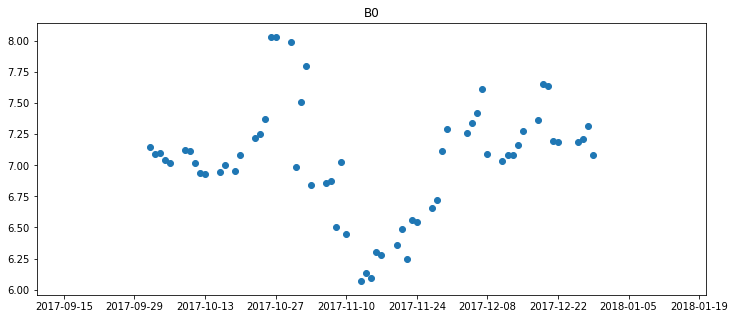

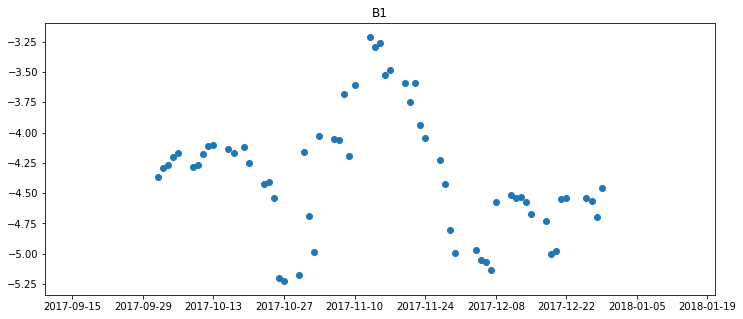

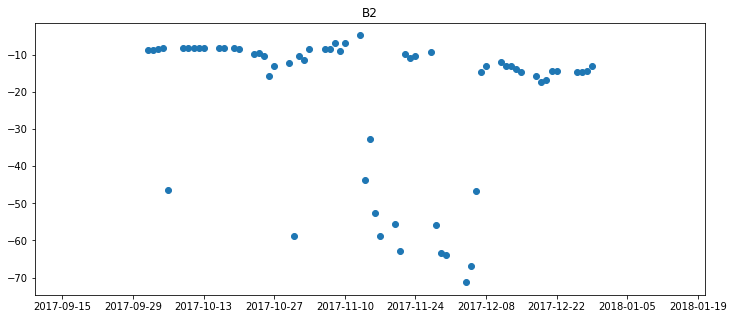

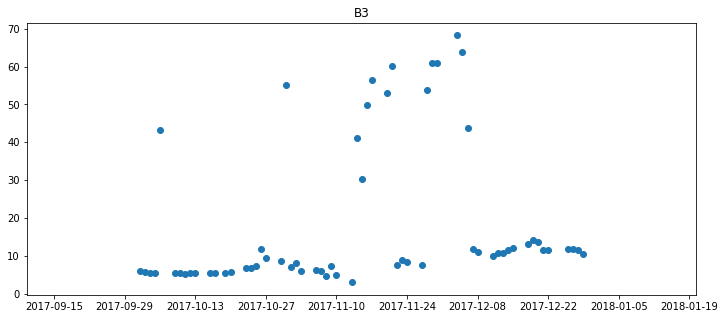

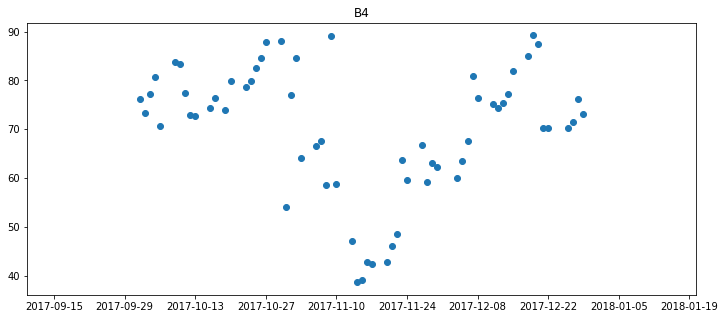

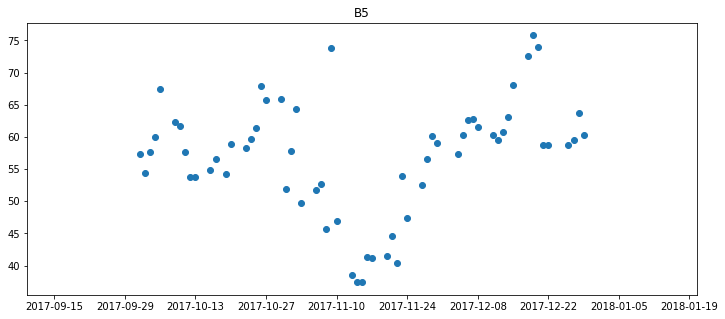

In [19]:
t = df_params.columns
#t=(t/ np.timedelta64(1, 'D')).astype(int)

for i in range(0,6):
    plt.figure(figsize=(12,5))
    plt.title("B"+str(i))
    plt.scatter(t,df_params.iloc[i,:])
    plt.plot

In [20]:
np.mean(df_params.iloc[4,:].values), np.std(df_params.iloc[4,:].values)

(70.02398196993286, 13.235471769914742)

In [21]:
np.mean(df_params.iloc[5,:].values), np.std(df_params.iloc[5,:].values)

(57.01744840891639, 8.856371062455782)

In [22]:
df.iloc[-1]

3      2.733
6      2.784
12     2.906
24     3.109
36     3.324
60     3.664
84     3.947
120    3.947
180    4.525
240    4.843
300    5.068
360    5.370
Name: 2017-12-29 00:00:00, dtype: float64

In [23]:
df_params.iloc[:,-1]

0     7.084968
1    -4.458074
2   -13.120869
3    10.464491
4    73.092729
5    60.355572
Name: 2017-12-29 00:00:00, dtype: float64

In [24]:
df.iloc[-1]-pred.iloc[-1]

3      0.026255
6      0.002060
12    -0.013643
24    -0.043188
36    -0.016075
60     0.037859
84     0.105919
120   -0.154167
180    0.051284
240    0.032972
300   -0.039235
360    0.009954
Name: 2017-12-29 00:00:00, dtype: float64

In [25]:
df_params.transpose().corr()

,0,1,2,3,4,5
0,1.000000,-0.940883,0.173808,-0.191162,0.831598,0.859825
1,-0.940883,1.000000,0.005760,0.007437,-0.714642,-0.836201
2,0.173808,0.005760,1.000000,-0.999702,0.567070,0.211538
3,-0.191162,0.007437,-0.999702,1.000000,-0.577572,-0.221420
4,0.831598,-0.714642,0.567070,-0.577572,1.000000,0.889762
5,0.859825,-0.836201,0.211538,-0.221420,0.889762,1.000000
